# Baseline Analysis

Now that we have cleaned our data and removed duplicates, we can take a look at some basic features of the dataset. 

In [100]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

PICKLE_PATH = Path("../pickled_data/")

# read in the plays data
game_plays = pd.read_pickle(PICKLE_PATH / 'game_plays')

In [2]:
game_plays.dtypes

play_id                 object
game_id                  int64
team_id_for            float64
team_id_against        float64
event                   object
secondaryType           object
x                      float64
y                      float64
period                   int64
periodType              object
periodTime               int64
periodTimeRemaining    float64
dateTime                object
goals_away               int64
goals_home               int64
description             object
st_x                   float64
st_y                   float64
dtype: object

In [3]:
game_plays['event'].value_counts()

event
Faceoff                     743979
Shot                        698365
Hit                         587574
Stoppage                    581172
Blocked Shot                358851
Missed Shot                 296389
Penalty                     229228
Giveaway                    219864
Takeaway                    173246
Goal                        133345
Period Start                 41663
Period Ready                 41614
Period End                   41609
Period Official              41608
Game End                     12462
Game Scheduled               12458
Shootout Complete             1274
Game Official                 1267
Official Challenge            1028
Early Intermission Start        31
Early Intermission End          31
Emergency Goaltender             5
Name: count, dtype: int64

In [4]:
# Shots by shot type
shots = game_plays[game_plays['event'] == 'Shot']
shot_count = shots.groupby('secondaryType')['play_id'].count().sort_values(ascending=False)

In [5]:
# Goals by shot type
goals = game_plays[game_plays['event'] == 'Goal']
goal_count = goals.groupby('secondaryType')['play_id'].count().sort_values(ascending=False)

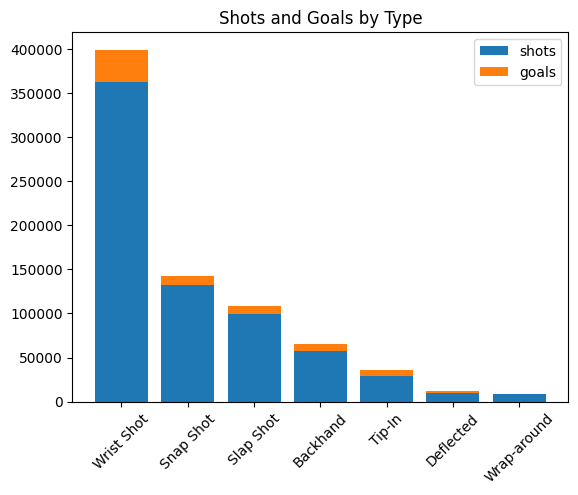

In [6]:
# create a stacked bar with shots and goal separated by type
shot_types = goal_count.index
counts = {
    "shots": shot_count,
    "goals": goal_count
}

fig, ax = plt.subplots()
bottom=np.zeros(len(goal_count))
for name, count in counts.items():
    ax.bar(shot_types, count, label=name, bottom=bottom)
    bottom += count
    
ax.set_title('Shots and Goals by Type')
ax.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()


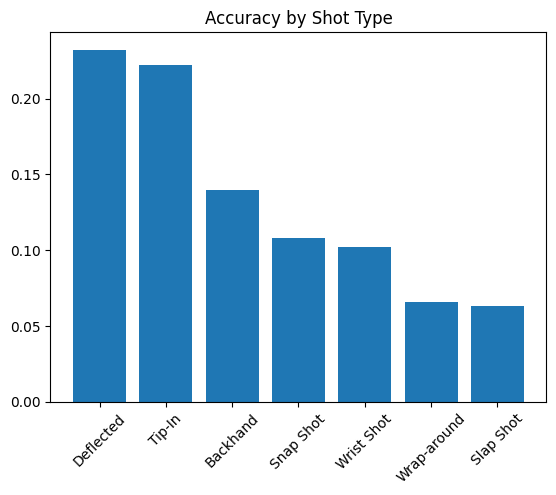

In [7]:
# Plot accuracy (goals/shots) for shot types
accuracy = goal_count / shot_count
accuracy.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
ax.bar(accuracy.index, accuracy)

ax.set_title("Accuracy by Shot Type")
plt.xticks(rotation=45)
plt.show()

In [ ]:
def calculate_total_time(df):
    """Calculates total elapsed game time in seconds, given period and time_elapsed (seconds).

    Args:
        df: Pandas DataFrame with 'period' and 'periodTime' (in seconds) columns.

    Returns:
        Pandas DataFrame with a new 'total_time' column (in seconds).
        Returns the original DataFrame if there's an error.
    """
    df = df.copy() # create a copy of the DataFrame
    
    try:
        
        df['time_elapsed'] = pd.to_numeric(df['periodTime'], errors='coerce')  # Convert to numeric, handle errors

        # Calculate total seconds for each period:
        df['period_seconds'] = (df['period'] - 1) * 1200  # 1200 seconds per period (20 minutes)

        # Calculate total time:
        df['total_time'] = df['period_seconds'] + df['time_elapsed']

        df = df.drop(columns=['period_seconds'])  # Clean up unnecessary column

        return df
    
    except (TypeError, ValueError) as e:
        print(f"Error during time calculation: {e}")
        return df

shots = calculate_total_time(shots)

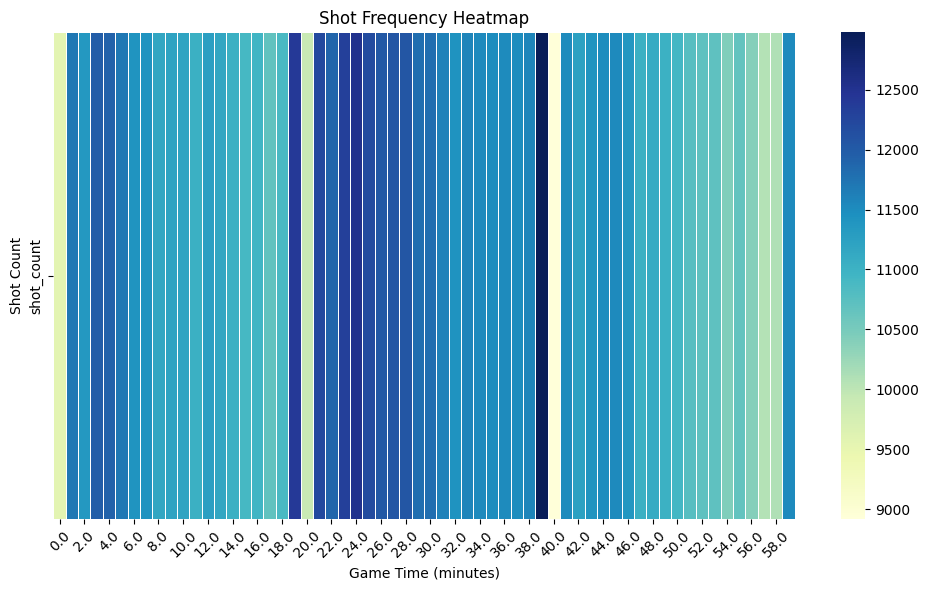

In [ ]:
# Heatmap for shot frequency over time of game
# Create bins for time intervals 
bin_size = 60  # Seconds per bin 
bins = range(0, 3601, bin_size)  # Create the bin edges
shots['time_bin'] = pd.cut(shots['total_time'], bins=bins, right=False, labels=False) # Assign each shot to a time bin

# Aggregate shot counts by time bin:
shot_counts = shots.groupby('time_bin').size().reset_index(name='shot_count')

# Convert time_bin back to seconds for plotting:
shot_counts['time_bin_seconds'] = shot_counts['time_bin'] * bin_size

# Create the heatmap:
plt.figure(figsize=(10, 6)) 

# Convert seconds to minutes for the x-axis labels 
shot_counts['time_bin_minutes'] = shot_counts['time_bin_seconds'] / 60

sns.heatmap(shot_counts.pivot_table(index=None, columns='time_bin_minutes', values='shot_count', aggfunc='sum'), cmap="YlGnBu", linewidths=.5)  # Use pivot_table for heatmap
plt.xlabel("Game Time (minutes)")
plt.ylabel("Shot Count")
plt.title("Shot Frequency Heatmap")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


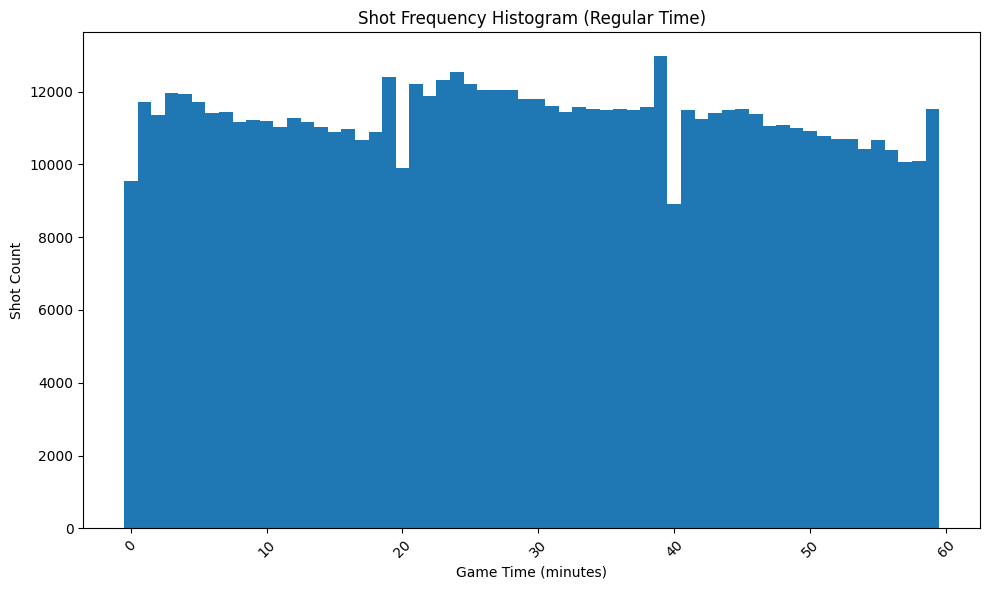

In [10]:
# Histogram of shot count frequency by game time elapsed
plt.figure(figsize=(10, 6))
plt.bar(shot_counts['time_bin_minutes'], shot_counts['shot_count'], width=bin_size/60)  # Use bin_size to determine bar width
plt.xlabel("Game Time (minutes)")
plt.ylabel("Shot Count")
plt.title("Shot Frequency Histogram (Regular Time)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

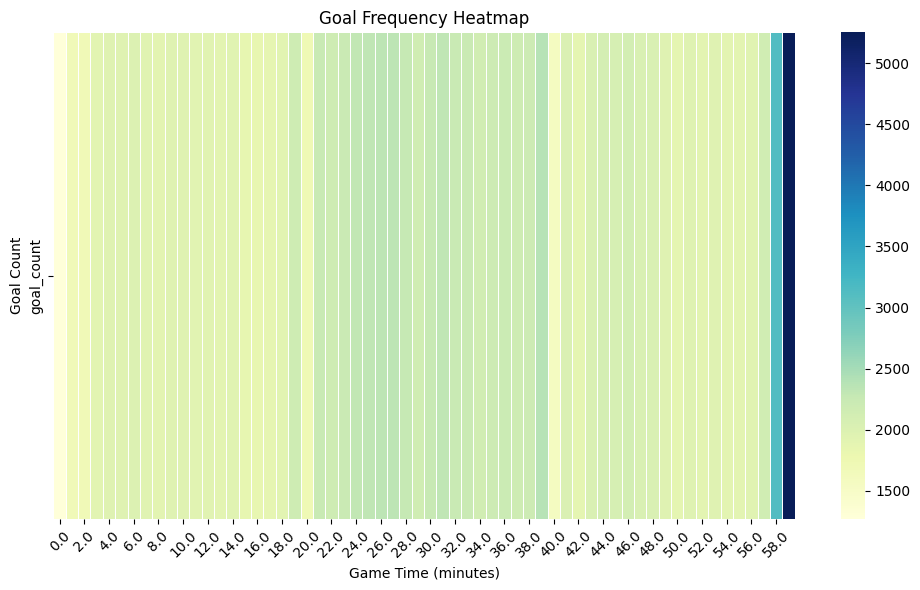

In [11]:
goals = calculate_total_time(goals)

# Create bins for time intervals 
bin_size = 60  # Seconds per bin 
bins = range(0, 3601, bin_size)  # Create the bin edges
goals['time_bin'] = pd.cut(goals['total_time'], bins=bins, right=False, labels=False) # Assign each shot to a time bin

# Aggregate shot counts by time bin:
goal_counts = goals.groupby('time_bin').size().reset_index(name='goal_count')

# Convert time_bin back to seconds for plotting:
goal_counts['time_bin_seconds'] = goal_counts['time_bin'] * bin_size

# Create the heatmap:
plt.figure(figsize=(10, 6)) 

# Convert seconds to minutes for the x-axis labels 
goal_counts['time_bin_minutes'] = goal_counts['time_bin_seconds'] / 60

sns.heatmap(goal_counts.pivot_table(index=None, columns='time_bin_minutes', values='goal_count', aggfunc='sum'), cmap="YlGnBu", linewidths=.5)  # Use pivot_table for heatmap
plt.xlabel("Game Time (minutes)")
plt.ylabel("Goal Count")
plt.title("Goal Frequency Heatmap")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

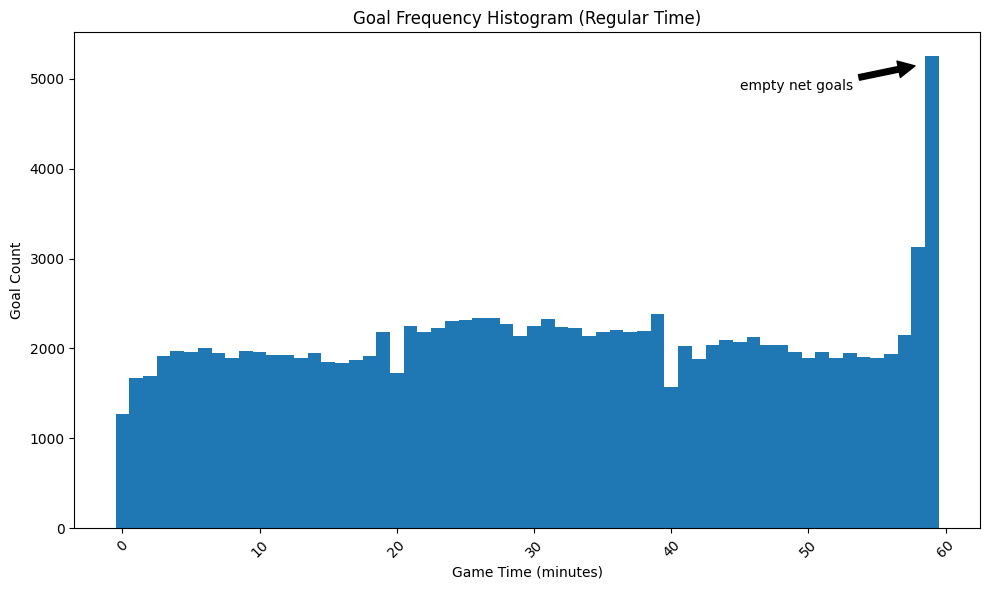

In [33]:
# Histogram of shot count frequency by game time elapsed
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(goal_counts['time_bin_minutes'], goal_counts['goal_count'], width=bin_size/60)  # Use bin_size to determine bar width
ax.annotate("empty net goals", xy=(58, 5150), xytext=(45, 5000), va="top", ha="left", arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel("Game Time (minutes)")
plt.ylabel("Goal Count")
plt.title("Goal Frequency Histogram (Regular Time)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

In [101]:
# Add columns for counting goals and shots
game_plays['goal'] = (game_plays['event'] == "Goal").astype(int)
game_plays['shot'] = (game_plays['event'] == "Shot").astype(int)

# Correct the x and y coordinates to occupy only one side of the ice
game_plays['xC'] = np.abs(game_plays['x'])
game_plays['yC'] = game_plays['y'] * np.sign(game_plays['x'])

# filter for goals and missing coordinates
goals = game_plays.loc[
    ~game_plays["xC"].isna() &
    ~game_plays["yC"].isna() &
    (game_plays['event'].isin(["Goal"]))
]
# keep only columns we need for performance
goals = goals[['xC', 'yC', 'goal']]

# filter for shots and missing coordinates
shots = game_plays.loc[
    ~game_plays["xC"].isna() &
    ~game_plays["yC"].isna() &
    (game_plays['event'].isin(["Shot"]))
]
# keep only columns we need for performance
shots = shots[['xC', 'yC', 'shot']]

Since we are given the (x,y) coordinates of our events, we can calculate the distance from the goal, and the angle of the shooter to the goal using some geometry.

The distance can be found simply using the Pythagorean distance. We can approximate the location of the goal as the center of it's opening at (89, 0). Then we can use the following formula to calculate the distance: 

$$D = \sqrt {(x - 89)^2 + (y - 0)^2}$$ 

We can measure the angle of the shot as the angle of intersection with an imaginary line down the center of the ice. We can also think of this as the angle a goaltender would have to apply to be completely "square" to the shot. This angle can be calculated using the formula: 

$$\theta = \tan^{-1} ({\frac {y}{89 - x}}) * \frac {180}{\pi}$$

Distance and angle (theta) are illustrated through the plot below:

[Text(77, 4, 'distance')]

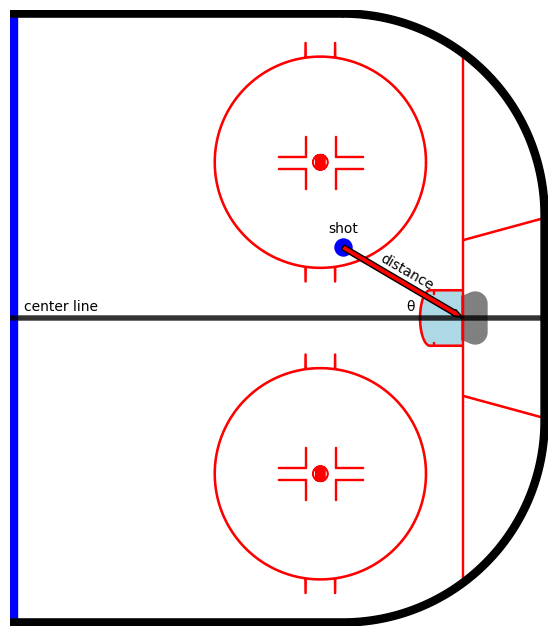

In [ ]:
# Center of goal is (89, 0)
from hockey_rink import NHLRink # this package allows annotation of the rink 

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl = NHLRink()
nhl.draw(ax = ax, display_range = "ozone")

nhl.scatter(x=72, y=10, color='blue', s=150)
nhl.arrow(x=72, y=10, x2=89, y2=0, facecolor = "red", length_includes_head=True, head_width=1)
nhl.arrow(x=25, y=0, x2=110, y2=0, facecolor="black", head_width=None, linestyle='--', linewidth=0.1, alpha=0.8)
nhl.text(x=70, y=12, s="shot")
nhl.text(x=81, y=1, s="θ")
nhl.text(x=27, y=1, s="center line")
nhl.text(x=77, y=4, s="distance", rotation=-30)

Let's apply our distance and angle formulas and look how they are distributed for shots and goals

In [102]:
# Calculate shot distance column
shots['distance'] = shots[['xC', 'yC']].apply(
    lambda row: np.sqrt((row['xC'] - 89)**2 + row['yC']**2),
    axis=1
    )
# Calculate shot angle column
shots['angle'] = shots[['xC', 'yC']].apply(
    lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi), 
    axis=1
    )

/tmp/ipykernel_148839/213725400.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi),


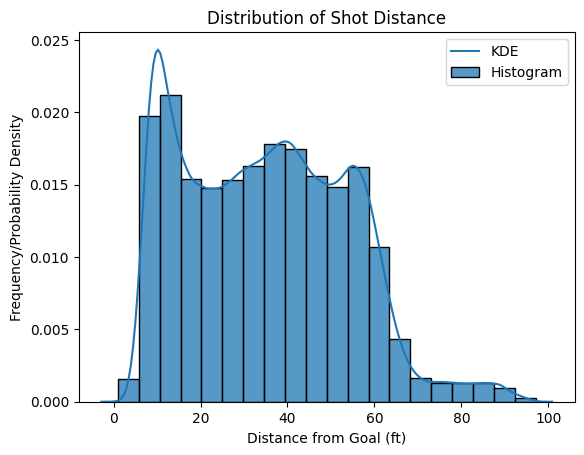

In [113]:
sns.histplot(shots['distance'], bins=20, stat="density", label="Histogram")
sns.kdeplot(shots['distance'], label='KDE') 

plt.xlabel("Distance from Goal (ft)")
plt.ylabel("Frequency/Probability Density")
plt.title("Distribution of Shot Distance")
plt.legend()
plt.show()

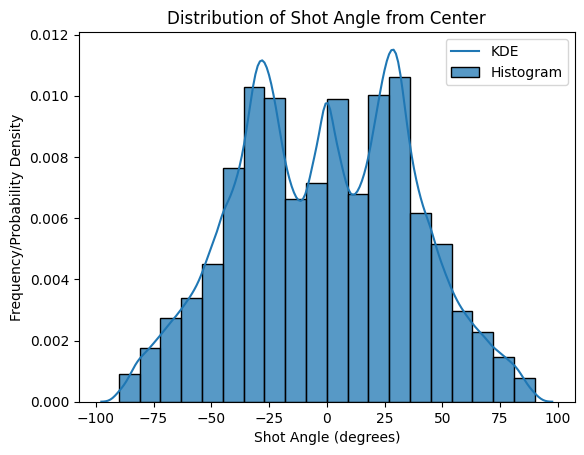

In [114]:
sns.histplot(shots['angle'], bins=20, stat="density", label="Histogram")
sns.kdeplot(shots['angle'], label='KDE') 

plt.xlabel("Shot Angle (degrees)")
plt.ylabel("Frequency/Probability Density")
plt.title("Distribution of Shot Angle from Center")
plt.legend()
plt.show()

In [109]:
goals['distance'] = goals[['xC', 'yC']].apply(
    lambda row: np.sqrt((row['xC'] - 89)**2 + row['yC']**2),
    axis=1
    )
# Calculate shot angle column
goals['angle'] = goals[['xC', 'yC']].apply(
    lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi), 
    axis=1
    )

/tmp/ipykernel_148839/858300658.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi),
/tmp/ipykernel_148839/858300658.py:7: RuntimeWarning: invalid value encountered in scalar divide
  lambda row: np.arctan(row['yC'] / (89 - row['xC'])) * (180 / np.pi),


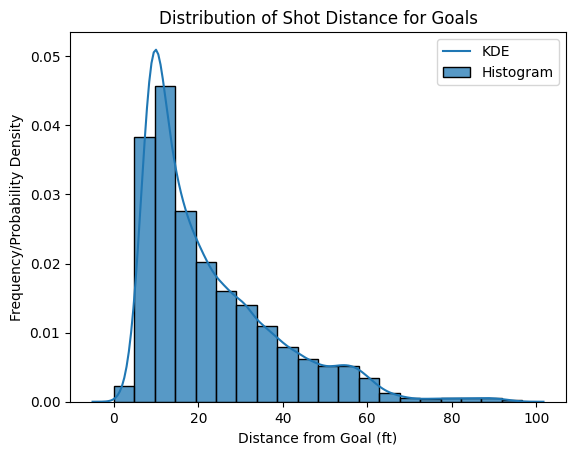

In [115]:
sns.histplot(goals['distance'], bins=20, stat="density", label="Histogram")
sns.kdeplot(goals['distance'], label='KDE') 

plt.xlabel("Distance from Goal (ft)")
plt.ylabel("Frequency/Probability Density")
plt.title("Distribution of Shot Distance for Goals")
plt.legend()
plt.show()

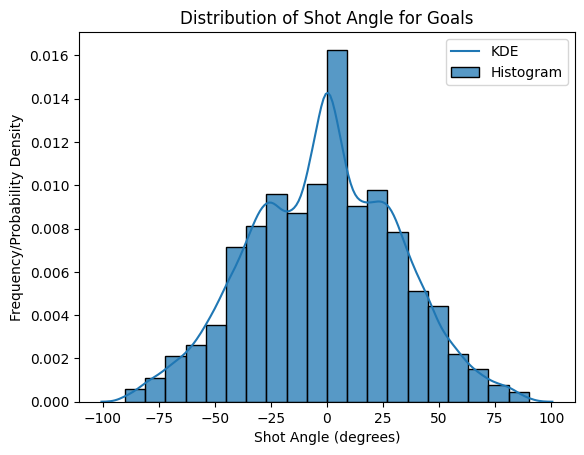

In [116]:
sns.histplot(goals['angle'], bins=20, stat="density", label="Histogram")
sns.kdeplot(goals['angle'], label='KDE') 

plt.xlabel("Shot Angle (degrees)")
plt.ylabel("Frequency/Probability Density")
plt.title("Distribution of Shot Angle for Goals")
plt.legend()
plt.show()

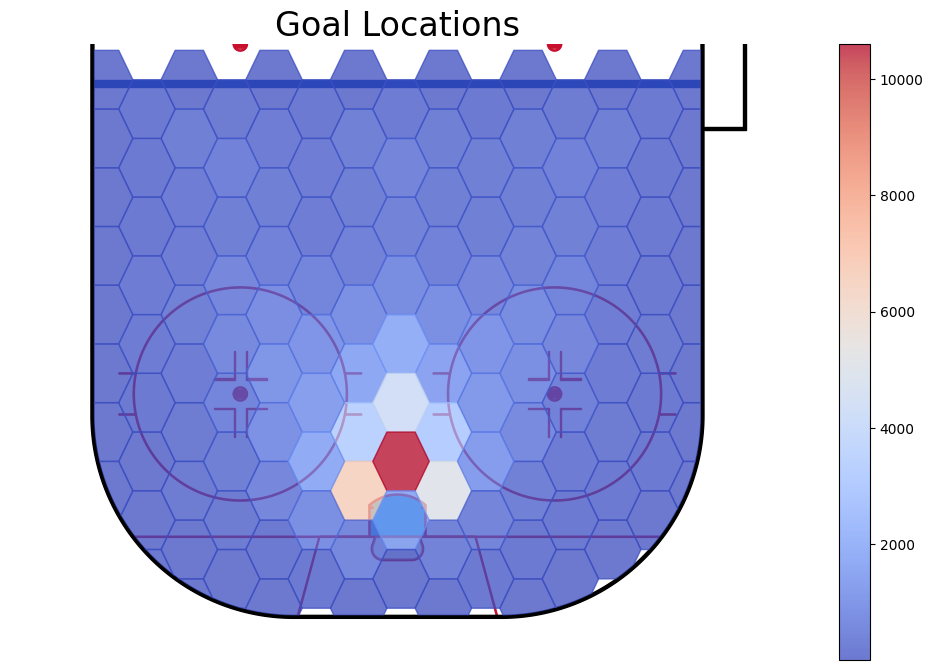

In [75]:
from sportypy.surfaces.hockey import NHLRink

nhl = NHLRink()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl.draw(ax, display_range="ozone", rotation=270)
hex = nhl.hexbin(
    goals["xC"],
    goals["yC"],
    values = goals["goal"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    binsize = (8, 12),
    zorder=30,
    alpha=0.75
)

ax.set_title("Goal Locations", fontsize=24)
plt.colorbar(hex, ax=ax)

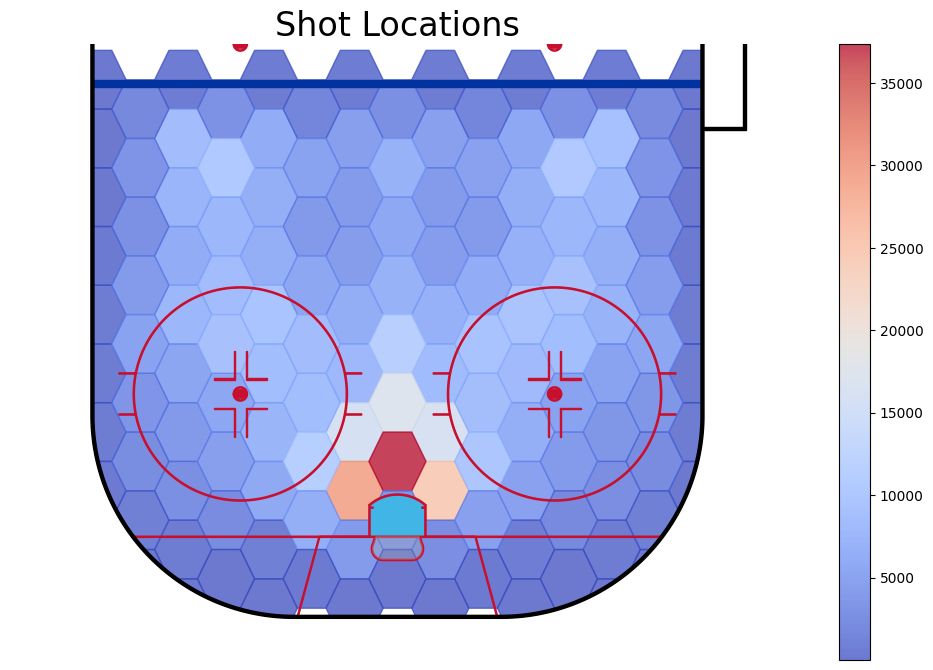

In [86]:
nhl = NHLRink()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl.draw(ax, display_range="ozone", rotation=270)
hex = nhl.hexbin(
    shots["xC"],
    shots["yC"],
    values = shots["shot"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    binsize = (8, 12),
    zorder=5,
    alpha=0.75
)

ax.set_title("Shot Locations", fontsize=24)
plt.colorbar(hex, ax=ax)

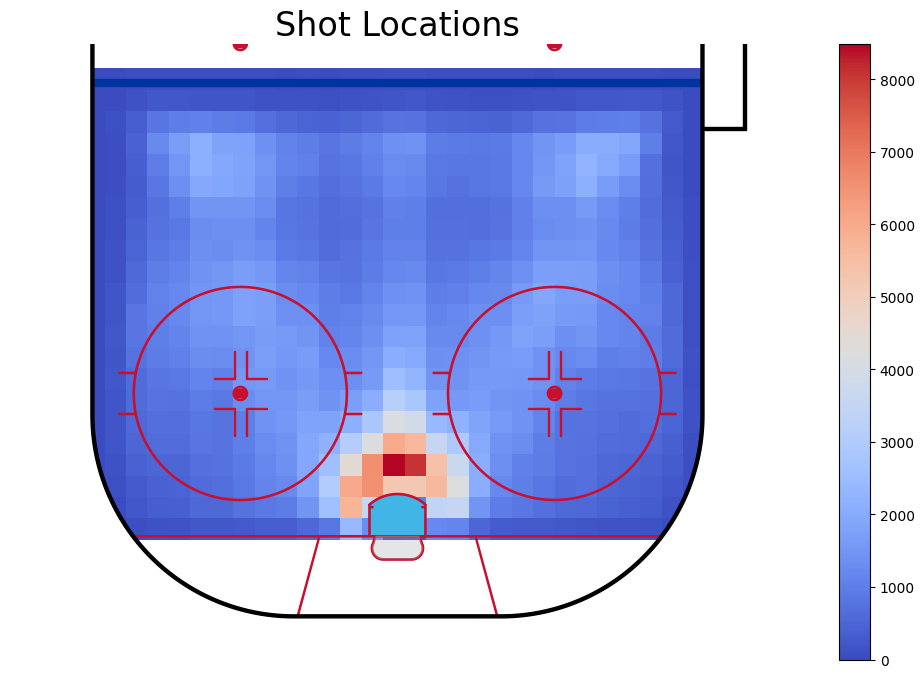

In [97]:
nhl = NHLRink()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl.draw(ax, display_range="ozone", rotation=270)
heat = nhl.heatmap(
    shots["xC"],
    shots["yC"],
    values = shots["shot"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    plot_xlim=(25, 89),
    binsize=3
)

ax.set_title("Shot Locations", fontsize=24)
plt.colorbar(heat, ax=ax)

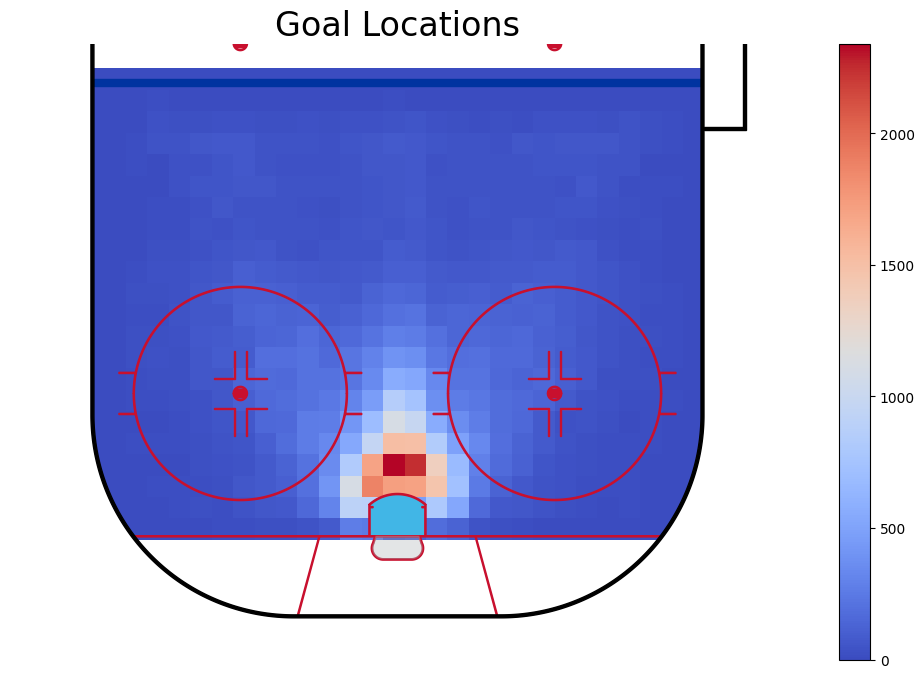

In [98]:
nhl = NHLRink()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
nhl.draw(ax, display_range="ozone", rotation=270)
heat = nhl.heatmap(
    goals["xC"],
    goals["yC"],
    values = goals["goal"],
    cmap = "coolwarm",
    ax = ax,
    plot_range="ozone",
    plot_xlim=(25, 89),
    binsize=3
)

ax.set_title("Goal Locations", fontsize=24)
plt.colorbar(heat, ax=ax)